# SKEMPI 2.0 benchmark: data filtraton and processing

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import math

In [36]:
# Load the dataset

skempi2 = pd.read_csv('skempi_v2.csv', sep=';') # 7085 rows

In [37]:
skempi2['N_mut'] = skempi2['Mutation(s)_PDB'].str.split(',').str.len()
#skempi2['N_mut'] = skempi2['N_mut'].apply(lambda x: '3+' if x >= 3 else x)
#skempi2['N_mut'] = skempi2['N_mut'].apply(str)

In [38]:
skempi2['Entry'] = skempi2.index + 1

In [39]:
S2536 = pd.read_csv('S2536.csv', sep=';', na_values='XXX')
entries_merged = S2536['Entry'].to_list()
entry_index = list()
for e in entries_merged:
    entrie_num = e.split(',')
    for en in entrie_num:
        entry_index.append(int(en))
    
with open("S2536_entry_index.txt", "w") as output:
    for e in entry_index:
        output.write(str(e))
        output.write('\n')

In [ ]:
with open("skempi2_raw_entry_index.txt", "w") as output:
    output.write(str(skempi2['Entry'].to_list()))

In [41]:
skempi2['S2536'] = False
skempi2.loc[skempi2['Entry'].isin(entry_index), 'S2536'] = True

In [42]:
def custom_mean_std(series):
    # Convert to numeric, errors='coerce' turns non-numeric values into NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    # Return the mean, skipping NaN values
    return (numeric_series.mean(skipna=True), numeric_series.std(skipna=True))

In [43]:
original_skempi_len = len(skempi2)

In [44]:
# Get a list of uniqie PDB IDs in the dataset 

pdb_list = skempi2['#Pdb'].str.split("_").str[0].unique().tolist()
print(f"{len(pdb_list)} unique PDB IDs") # 345

345 unique PDB IDs


Uncomment to generate a text file with PDB ID list -- required for RCSB batch download script (https://www.rcsb.org/docs/programmatic-access/batch-downloads-with-shell-script):


In [45]:
# with open('pdb_list.txt', 'w') as f:
#     for pdb in pdb_list:
#         f.write(f"{pdb},")

In [46]:
# Get a separate PDB ID column

skempi2['PDB_ID'] = skempi2['#Pdb'].str.split('_').str[0]

## Step 1: Dropping and counting duplicates

In [47]:
# Possibly just a mistake? I checked row by row, field by field, and didn't see anything.

print(f"{len(skempi2.loc[skempi2.duplicated()])} entries are duplicated. {len(skempi2.loc[skempi2.duplicated()].loc[skempi2['SKEMPI version']==2])} of them are added in SKEMPI version 2.0")
print("Dropping the duplicates.")

skempi2.drop_duplicates(inplace=True, ignore_index=True) # 7074 rows (11 duplicated, 10 from SKEMPI 2.0)

print(f"New dataset size: {len(skempi2)}")

0 entries are duplicated. 0 of them are added in SKEMPI version 2.0
Dropping the duplicates.
New dataset size: 7085


## Step 2: Counting cases with unprecise binding affinity values

In [48]:
# Counts for cases with binding affinity values defined as smaller/larger then a certain detection threshold

out_of_range_total = skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<',
            '>')))|(skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))]

out_of_range_wt_mut = skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<',
            '>')))&(skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))]

out_of_range_wt = skempi2.loc[(skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))&(~skempi2['Affinity_mut (M)'].str.startswith(('<', '>')))]

out_of_range_mut = skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<', '>')))&(~skempi2['Affinity_wt (M)'].str.startswith(('<', '>')))]

print(f"Total cases with wild-type and/or mutant complex binding affinity out of detection range: ")
print(f"{len(out_of_range_total)} ({round(len(out_of_range_total)/original_skempi_len*100, 2)}% of the dataset), {len(out_of_range_total['PDB_ID'].unique())} unique PDB structures \n") # 186, 2.63%, 47 

print(f"Total cases with binding affinities of BOTH WILD TYPE AND MUTANT complexes out of detection range: ")
print(f"{len(out_of_range_wt_mut)}, {len(out_of_range_wt_mut['PDB_ID'].unique())} unique PDB structures ({', '.join(out_of_range_wt_mut['PDB_ID'].unique().tolist())}), {len(out_of_range_wt_mut['Method'].unique())} uniqie methods ({', '.join(out_of_range_wt_mut['Method'].unique())}) \n") # 14, 2 (4I77, 1CZ8), SPR

print(f"Total cases with binding affinities of WILD TYPE complexes out of detection range: ")
print(f"{len(out_of_range_wt)}, {len(out_of_range_wt['PDB_ID'].unique())} unique PDB structures ({', '.join(out_of_range_wt['PDB_ID'].unique().tolist())}), {len(out_of_range_wt['Method'].unique())} uniqie methods ({', '.join(out_of_range_wt['Method'].unique())}) \n") # 27, 2 (4I77, 1CZ8), SPR

print(f"Total cases with binding affinities of MUTANT complexes out of detection range: ")
print(f"{len(out_of_range_mut)}, {len(out_of_range_mut['PDB_ID'].unique())} unique PDB structures ({', '.join(out_of_range_mut['PDB_ID'].unique().tolist())}), {len(out_of_range_mut['Method'].unique())} uniqie methods ({', '.join(out_of_range_mut['Method'].unique())})") # 145, 45

print("\nThose values are parsed by SKEMPI itself as a threshold value, e. g. '>5E-05' becomes 0.00005")

Total cases with wild-type and/or mutant complex binding affinity out of detection range: 
186 (2.63% of the dataset), 47 unique PDB structures 

Total cases with binding affinities of BOTH WILD TYPE AND MUTANT complexes out of detection range: 
14, 2 unique PDB structures (4I77, 1CZ8), 1 uniqie methods (SPR) 

Total cases with binding affinities of WILD TYPE complexes out of detection range: 
27, 2 unique PDB structures (4I77, 1CZ8), 1 uniqie methods (SPR) 

Total cases with binding affinities of MUTANT complexes out of detection range: 
145, 45 unique PDB structures (1SBB, 1JCK, 1AK4, 1AHW, 1VFB, 2WPT, 2JEL, 2OOB, 2A9K, 1REW, 1HE8, 3BN9, 2FTL, 1A22, 1FCC, 3HFM, 1SMF, 1OGA, 2P5E, 2PYE, 3QDJ, 1MI5, 2AK4, 1AO7, 3G6D, 3Q8D, 4B0M, 1BJ1, 1MHP, 1MLC, 3SE3, 3SE4, 4KRL, 4KRO, 4KRP, 4OZG, 4PWX, 2C5D, 4RS1, 1C1Y, 4G0N, 1LFD, 5XCO, 2KSO, 3QIB), 12 uniqie methods (SE, SPR, IASP, FL, SFFL, CSPRIA, ITC, IARA, IAFL, ELISA, SP, KinExA)

Those values are parsed by SKEMPI itself as a threshold value, e

In [49]:
skempi2['Kd_val_type'] = 'Regular'

skempi2.loc[skempi2['Affinity_mut (M)'].str.startswith('<'),'Kd_val_type'] = 'MUT stronger than threshold'
skempi2.loc[skempi2['Affinity_mut (M)'].str.startswith('>'), 'Kd_val_type'] = 'MUT weaker than threshold'

skempi2.loc[skempi2['Affinity_wt (M)'].str.startswith('<'),'Kd_val_type'] = 'WT stronger than threshold'
skempi2.loc[skempi2['Affinity_wt (M)'].str.startswith('>'), 'Kd_val_type'] = 'WT weaker than threshold'

skempi2.loc[(skempi2['Affinity_mut (M)'].str.startswith(('<',
            '>')))&(skempi2['Affinity_wt (M)'].str.startswith(('<', '>'))), 'Kd_val_type'] = 'Both WT and MUT are out of range'

#### **To Do:** separate "smaller than" from "bigger than" in a meaning full way (e.g. "very strong interaction" vs "very weak")

## Step 2: Calculating binding dG of the wild type and mutant complexes from binding affinities, calculating binding ddG, filtering out and solving ddG_bind is NaN cases

In [50]:
# Using ΔG = R*T*ln(Kd)

skempi2['dG_bind_WT'] =  0.001987204 * skempi2['Temperature'].str.extract('(\d+)'
                        ).values.astype(float).reshape(-1) * np.log(skempi2['Affinity_wt_parsed'].values)
skempi2['dG_bind_MUT'] = 0.001987204 * skempi2['Temperature'].str.extract('(\d+)'
                        ).values.astype(float).reshape(-1) * np.log(skempi2['Affinity_mut_parsed'].values)
skempi2['ddG_bind'] = skempi2['dG_bind_MUT'].values - skempi2['dG_bind_WT'].values

In [51]:
skempi2.loc[skempi2['Kd_val_type']!='Regular', 'ddG_bind'] = np.nan

In [52]:
ddG_bind_na = skempi2.loc[skempi2['ddG_bind'].isna()]

print(f"Total cases with binding ddG being NaN: {len(ddG_bind_na)} ({round(len(ddG_bind_na)/original_skempi_len*100, 2)}% of the dataset), {len(ddG_bind_na['#Pdb'].str[0:4].unique())} unique PDB structures)")
print(f"From them:")
print(f"{len(skempi2.loc[skempi2['Temperature'].isna()])} do not have a temperature value")
print(f"{len(skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.'])])} are classified as 'no interaction' for mutant")
print(f"{len(skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.'])])} are classified as 'no interaction' for wild type")
print(f"{len(skempi2.loc[skempi2['Affinity_mut (M)']=='unf'])} are classified as 'unfolded mutant'")

print("\nSanity check: ")
print(f"{len(skempi2.loc[skempi2['Temperature'].isna()])} + {len(skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.'])])} + {len(skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.'])])} + {len(skempi2.loc[skempi2['Affinity_mut (M)']=='unf'])} = {len(skempi2.loc[skempi2['Temperature'].isna()]) + len(skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.'])]) + len(skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.'])]) + len(skempi2.loc[skempi2['Affinity_mut (M)']=='unf'])}")

Total cases with binding ddG being NaN: 475 (6.7% of the dataset), 107 unique PDB structures)
From them:
4 do not have a temperature value
278 are classified as 'no interaction' for mutant
2 are classified as 'no interaction' for wild type
7 are classified as 'unfolded mutant'

Sanity check: 
4 + 278 + 2 + 7 = 291


Keeping the cases with no dG values, dropping the cases without temperature values.

In [53]:
# Drop cases without temperature values -- we cannot calculate binding ddGs for that

skempi2 = skempi2.loc[~skempi2['Temperature'].isna()].reset_index() # 7070

In [54]:
# To keep track of cases without a value for binding affinities -- we might assign them new values for comparison with predictors

skempi2.loc[skempi2['Affinity_mut (M)'].isin(['n.b', 'n.b.']), 'Kd_val_type'] = 'no binding MUT'
skempi2.loc[skempi2['Affinity_wt (M)'].isin(['n.b', 'n.b.']), 'Kd_val_type'] = 'no binding WT'
skempi2.loc[skempi2['Affinity_mut (M)']=='unf', 'Kd_val_type'] = 'unfolded MUT'

## Step 3: Filtering out values with disagreeing measurements by multiple methods, calculating the average

#### **To Do:** analysis of errors in dG_mut, dG_wt and ddG

In [215]:
groups_with_diff_c = skempi2[['#Pdb', 'Mutation(s)_PDB', 'dG_bind_WT', 'dG_bind_MUT', 'ddG_bind', 'Kd_val_type']].groupby(['#Pdb', 'Mutation(s)_PDB']).filter(lambda x: x['Kd_val_type'].nunique() > 1)

In [216]:
groups_with_diff_c

#Pdb                 Mutation(s)_PDB  dG_bind_WT  dG_bind_MUT  \
212      1SBB_A_B               LB20T,VB26Y,YB91V   -5.254988          NaN   
214      1JCK_A_B                           NB23A   -7.530779          NaN   
217      1JCK_A_B                           YB90A   -7.530779    -4.935801   
221      1JCK_A_B                          QB210A   -7.530779          NaN   
225      1SBB_A_B               LB20T,VB26Y,YB91V   -5.346274    -5.214131   
227      1JCK_A_B                           NB23A   -7.290668    -5.214131   
230      1JCK_A_B                           YB90A   -7.290668    -5.214131   
235      1JCK_A_B                          QB210A   -7.290668    -5.214131   
651      2AJF_A_E                          TE487S  -10.622797    -8.799679   
2149    3HFM_HL_Y                           KY96A  -14.348582    -7.360418   
2261    3HFM_HL_Y                           KY96A  -13.846823    -7.360418   
3624  1BD2_ABC_DE                            YC5A   -7.969553    -4.563547   
3633  1BD2_ABC_DE                            YC5A   -7.839900    -4.564865   
3685  1AO7_ABC_DE                           RA65A   -7.602011    -4.373768   
3694  1AO7_ABC_DE                           RA65A   -7.653133    -4.546682   
3706  1AO7_ABC_DE                            YC8A   -7.522936    -4.356820   
3806  1BD2_ABC_DE                            YC5A   -8.003645          NaN   
3822  1AO7_ABC_DE                           KA66A   -7.706428    -4.772888   
3827  1AO7_ABC_DE                            YC8A   -8.237212          NaN   
3904  1AO7_ABC_DE                           RA65A   -8.237212    -5.557492   
3905  1AO7_ABC_DE                           KA66A   -8.237212    -6.447130   
3941  1AO7_ABC_DE                           RA65A   -8.257064    -5.102882   
3942  1AO7_ABC_DE                           KA66A   -8.257064    -5.102882   
4571    4K71_A_BC     MA418V,AA420T,GA505E,AA547V  -11.621461    -8.163859   
4576    4K71_A_BC     MA418V,AA420T,GA505E,AA547V  -11.040627    -7.228275   
4580    4K71_A_BC     MA418V,AA420T,GA505E,AA547V   -7.100889          NaN   
4723     2AJF_A_E                          TE487S  -10.474785          NaN   
4728    4I77_HL_Z                          YH100F  -14.999165   -14.999165   
4734    4I77_HL_Z                           YL28A  -14.999165   -14.999165   
4740    4I77_HL_Z                          YH100F  -15.603159   -14.947261   
4746    4I77_HL_Z                           YL28A  -15.603159   -13.973027   
4869   1BJ1_HL_VW  ML4L,TH28D,NH31H,HH101Y,SH105T  -11.641537   -13.436350   
4870   1BJ1_HL_VW  ML4L,TH28D,NH31H,HH101Y,SH105T  -11.186127   -12.707506   
4871   1CZ8_HL_VW  LL4M,DH28T,HH31N,YH101H,TH105S  -13.436350   -11.641537   
4872   1CZ8_HL_VW  LL4M,DH28T,HH31N,YH101H,TH105S  -14.125975   -11.186127   

      ddG_bind                       Kd_val_type  
212        NaN                    no binding MUT  
214        NaN                    no binding MUT  
217   2.594978                           Regular  
221        NaN                    no binding MUT  
225   0.132143         MUT weaker than threshold  
227   2.076537         MUT weaker than threshold  
230   2.076537         MUT weaker than threshold  
235   2.076537         MUT weaker than threshold  
651   1.823118                           Regular  
2149  6.988164                           Regular  
2261  6.486405         MUT weaker than threshold  
3624  3.406006                           Regular  
3633  3.275035                           Regular  
3685  3.228243                           Regular  
3694  3.106451                           Regular  
3706  3.166115                           Regular  
3806       NaN                    no binding MUT  
3822  2.933540                           Regular  
3827       NaN                    no binding MUT  
3904  2.679721                           Regular  
3905  1.790082                           Regular  
3941  3.154183         MUT weaker than threshold  
3942  3.154183         MUT weak

In [55]:
skempi2['Mutation(s)_PDB'] = skempi2['Mutation(s)_PDB'].apply(lambda x: ','.join(sorted(x.split(','))))

In [56]:
skempi2['interaction_strength'] = 'None'

In [57]:
skempi2.loc[skempi2['Affinity_wt_parsed']>=10**(-3), 'interaction_strength'] = 'ultra-weak'
skempi2.loc[(skempi2['Affinity_wt_parsed']<10**(-3))&(skempi2['Affinity_wt_parsed']>=10**(-6)), 'interaction_strength'] = 'weak'
skempi2.loc[(skempi2['Affinity_wt_parsed']<10**(-6))&(skempi2['Affinity_wt_parsed']>=10**(-9)), 'interaction_strength'] = 'moderate'
skempi2.loc[skempi2['Affinity_wt_parsed']<10**(-9), 'interaction_strength'] = 'strong'

In [58]:
skempi2['interaction_strength'].value_counts()

strong      2966
moderate    2888
weak        1225
None           2
Name: interaction_strength, dtype: int64

<AxesSubplot: xlabel='interaction_strength', ylabel='count'>

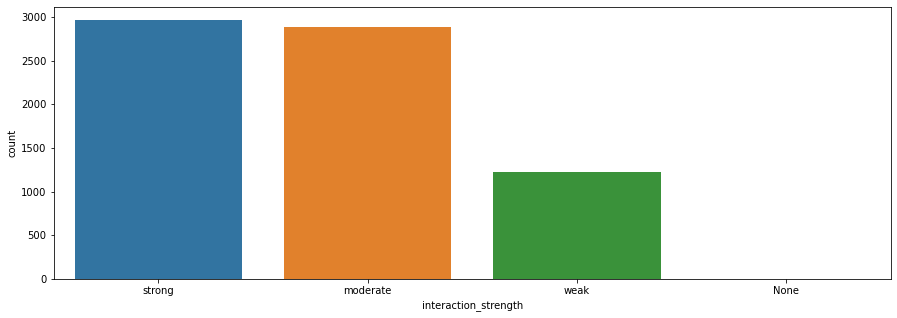

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=skempi2, x='interaction_strength', ax=ax)

In [223]:
skempi2.loc[skempi2['interaction_strength']=='strong']['Hold_out_type'].value_counts()

Pr/PI          1261
AB/AG           337
AB/AG,Pr/PI      62
TCR/pMHC         12
Name: Hold_out_type, dtype: int64

In [224]:
skempi2.loc[skempi2['interaction_strength']=='moderate']['Hold_out_type'].value_counts()

AB/AG       807
TCR/pMHC     98
Pr/PI        80
Name: Hold_out_type, dtype: int64

In [225]:
skempi2.loc[skempi2['interaction_strength']=='weak']['Hold_out_type'].value_counts()

TCR/pMHC    639
Pr/PI         8
AB/AG         5
Name: Hold_out_type, dtype: int64

In [226]:
skempi2.loc[skempi2['Hold_out_type']=='Pr/PI']['Affinity_wt_parsed'].median()

1.8e-11

In [227]:
skempi2.loc[skempi2['Hold_out_type']=='Pr/PI']['Affinity_wt_parsed'].min()

5e-14

In [228]:
skempi2.loc[skempi2['Hold_out_type']=='Pr/PI']['Affinity_wt_parsed'].max()

6.67e-05

In [229]:
skempi2.loc[skempi2['Hold_out_type']=='TCR/pMHC']['Affinity_wt_parsed'].median()

5.2e-06

In [230]:
skempi2.loc[skempi2['Hold_out_type']=='TCR/pMHC']['Affinity_wt_parsed'].min()

4.77e-11

In [231]:
skempi2.loc[skempi2['Hold_out_type']=='TCR/pMHC']['Affinity_wt_parsed'].max()

0.00014

In [139]:
skempi2.loc[skempi2['Hold_out_type']=='TCR/pMHC']

#Pdb Mutation(s)_PDB Mutation(s)_cleaned iMutation_Location(s)  \
3524  2VLR_ABC_DE           AE99S               AE95S                   SUP   
3525  1OGA_ABC_DE           DE32A               DE28A                   COR   
3526  1OGA_ABC_DE           DE32S               DE28S                   COR   
3527  1OGA_ABC_DE           QE52A               QE48A                   COR   
3528  1OGA_ABC_DE           QE52E               QE48E                   COR   
...           ...             ...                 ...                   ...   
7080  3QIB_ABP_CD            KP9R                KP8R                   COR   
7081  3QIB_ABP_CD           TP12A               TP11A                   COR   
7082  3QIB_ABP_CD           TP12S               TP11S                   COR   
7083  3QIB_ABP_CD           TP12N               TP11N                   COR   
7084  3QIB_ABP_CD      YP7F,TP12S          YP6F,TP11S               COR,COR   

     Hold_out_type  Hold_out_proteins Affinity_mut (M)  Affinity_mut_parsed  \
3524      TCR/pMHC  TCR/pMHC,1JCK_A_B          5.2E-06             0.000005   
3525      TCR/pMHC  TCR/pMHC,1JCK_A_B          7.4E-05             0.000074   
3526      TCR/pMHC  TCR/pMHC,1JCK_A_B           >2E-04             0.000200   
3527      TCR/pMHC  TCR/pMHC,1JCK_A_B           >2E-04             0.000200   
3528      TCR/pMHC  TCR/pMHC,1JCK_A_B           >2E-04             0.000200   
...            ...                ...              ...                  ...   
7080      TCR/pMHC  TCR/pMHC,1JCK_A_B          2.4E-04             0.000240   
7081      TCR/pMHC  TCR/pMHC,1JCK_A_B         >1.1E-03             0.001100   
7082      TCR/pMHC  TCR/pMHC,1JCK_A_B         3.38E-05             0.000034   
7083      TCR/pMHC  TCR/pMHC,1JCK_A_B         4.34E-05             0.000043   
7084      TCR/pMHC  TCR/pMHC,1JCK_A_B         4.29E-05             0.000043   

     Affinity_wt (M)  Affinity_wt_parsed  ... koff_wt_parsed  \
3524         4.9E-06            0.000005  ...          0.290   
3525         5.2E-06            0.000005  ...            NaN   
3526         5.2E-06            0.000005  ...            NaN   
3527         5.2E-06            0.000005  ...            NaN   
3528         5.2E-06            0.000005  ...            NaN   
...              ...                 ...  ...            ...   
7080         5.5E-06            0.000005  ...          0.022   
7081         5.5E-06            0.000005  ...            NaN   
7082         5.5E-06            0.000005  ...          0.022   
7083         5.5E-06            0.000005  ...          0.022   
7084         5.5E-06            0.000005  ...          0.022   

     dH_mut (kcal mol^(-1)) dH_wt (kcal mol^(-1))  \
3524                    NaN                   NaN   
3525                    NaN                   NaN   
3526                    NaN                   NaN   
3527                    NaN                   NaN   
3528                    NaN                   NaN   
...                     ...                   ...   
7080                    NaN                   NaN   
7081                    NaN                   NaN   
7082                    NaN                   NaN   
7083                    NaN                   NaN   
7084                    NaN                   NaN   

     dS_mut (cal mol^(-1) K^(-1))  dS_wt (cal mol^(-1) K^(-1))  \
3524                          NaN                          NaN   
3525                          NaN                          NaN   
3526                          NaN                          NaN   
3527                          NaN                          NaN   
3528                          NaN                          NaN   
...                           ...                          ...   
7080                          NaN                          NaN   
7081                          NaN                          NaN   
7082                          NaN                          NaN   
7083                          NaN                

In [35]:
K_D_ratio = skempi2['Affinity_mut_parsed'].values/skempi2['Affinity_wt_parsed'].values

In [36]:
K_D_ratio

array([4.69642857e+01, 7.43750000e+00, 9.10714286e+04, ...,
       6.14545455e+00, 7.89090909e+00, 7.80000000e+00])

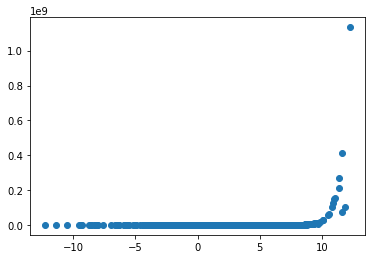

In [43]:
plt.scatter(skempi2['ddG_bind'].values, K_D_ratio)

In [70]:
math.exp(10)

22026.465794806718

In [51]:
skempi2['Affinity_wt_parsed'].min()

3.3e-16

In [52]:
skempi2['Affinity_wt_parsed'].max()

0.000635

In [58]:
skempi2.loc[skempi2['Affinity_wt_parsed']>0.0001][['#Pdb', 'Mutation(s)_PDB', 'Hold_out_proteins', 
                                                   'Affinity_mut (M)', 'Affinity_mut_parsed',
                                                   'Affinity_wt (M)','Affinity_wt_parsed',
                                                   'Protein 1', 'Protein 2',
                                                   'Method', 'SKEMPI version', 'dG_bind_WT',
                                                   'dG_bind_MUT', 'ddG_bind']]

#Pdb    Mutation(s)_PDB           Hold_out_proteins  \
209      1SBB_A_B              LB20T           1SBB_A_B,1JCK_A_B   
210      1SBB_A_B              VB26Y           1SBB_A_B,1JCK_A_B   
211      1SBB_A_B              YB91V           1SBB_A_B,1JCK_A_B   
212      1SBB_A_B  LB20T,VB26Y,YB91V           1SBB_A_B,1JCK_A_B   
222      1SBB_A_B              LB20T           1SBB_A_B,1JCK_A_B   
223      1SBB_A_B              VB26Y           1SBB_A_B,1JCK_A_B   
224      1SBB_A_B              YB91V           1SBB_A_B,1JCK_A_B   
225      1SBB_A_B  LB20T,VB26Y,YB91V           1SBB_A_B,1JCK_A_B   
682      1S1Q_A_B              VA43A  1S1Q_A_B,2OOB_A_B,3M63_A_B   
683      1S1Q_A_B              FA44A  1S1Q_A_B,2OOB_A_B,3M63_A_B   
684      1S1Q_A_B              NA45A  1S1Q_A_B,2OOB_A_B,3M63_A_B   
685      1S1Q_A_B              DA46A  1S1Q_A_B,2OOB_A_B,3M63_A_B   
686      1S1Q_A_B              WA75A  1S1Q_A_B,2OOB_A_B,3M63_A_B   
687      1S1Q_A_B              FA88A  1S1Q_A_B,2OOB_A_B,3M63_A_B   
3799  3PWP_ABC_DE               GC2L           TCR/pMHC,1JCK_A_B   
3800  3PWP_ABC_DE          GC2L,IC9V           TCR/pMHC,1JCK_A_B   
4596     3UIH_A_P        HA80W,KA62Y  3UIH_A_P,3UII_A_P,3UIG_A_P   

     Affinity_mut (M)  Affinity_mut_parsed Affinity_wt (M)  \
209           1.2E-04             0.000120         1.4E-04   
210           1.2E-05             0.000012         1.4E-04   
211           1.6E-04             0.000160         1.4E-04   
212               n.b                  NaN         1.4E-04   
222             1E-04             0.000100         1.2E-04   
223           2.6E-05             0.000026         1.2E-04   
224           1.4E-04             0.000140         1.2E-04   
225          >1.5E-04             0.000150         1.2E-04   
682          1.97E-03             0.001970        6.35E-04   
683          8.89E-04             0.000889        6.35E-04   
684          5.08E-03             0.005080        6.35E-04   
685          3.24E-03             0.003240        6.35E-04   
686          1.02E-03             0.001020        6.35E-04   
687          2.35E-03             0.002350        6.35E-04   
3799          4.8E-05             0.000048         1.4E-04   
3800          7.3E-05             0.000073         1.4E-04   
4596         1.98E-05             0.000020        1.21E-04   

      Affinity_wt_parsed                              Protein 1  \
209             0.000140                   Beta-chain of 14.3.d   
210             0.000140                   Beta-chain of 14.3.d   
211             0.000140                   Beta-chain of 14.3.d   
212             0.000140                   Beta-chain of 14.3.d   
222             0.000120                   Beta-chain of 14.3.d   
223             0.000120                   Beta-chain of 14.3.d   
224             0.000120                   Beta-chain of 14.3.d   
225             0.000120                   Beta-chain of 14.3.d   
682             0.000635  Tumor susceptibility gene 101 protein   
683             0.000635  Tumor susceptibility gene 101 protein   
684             0.000635  Tumor susceptibility gene 101 protein   
685             0.000635  Tumor susceptibility gene 101 protein   
686             0.000635  Tumor susceptibility gene 101 protein   
687             0.000635  Tumor susceptibility gene 101 protein   
3799            0.000140                HLA-A2 plus HuD peptide   
3800            0.000140                HLA-A2 plus HuD peptide   
4596            0.000121                               Survivin   

                         Protein 2 Method  SKEMPI version  dG_bind_WT  \
209   Staphylococcal enterotoxin B    SPR               1   -5.254988   
210   Staphylococcal enterotoxin B    SPR               1   -5.254988   
211   Staphylococcal enterotoxin B    SPR               1   -5.254988   
212   Staphylococcal enterotoxin B    SPR               2   -5.254988   
222   Staphylococcal enterotoxin B     SE               2   -5.346274   
223   Staphylococcal enter

In [55]:
skempi2.columns

Index(['index', '#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins',
       'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)',
       'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2',
       'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
       'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))',
       'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed',
       'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
       'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes',
       'Method', 'SKEMPI version', 'Entry', 'PDB_ID', 'Kd_val_type',
       'dG_bind_WT', 'dG_bind_MUT', 'ddG_bind'],
      dtype='object')

In [46]:
np.nanmin(K_D_ratio)

8.815592203898052e-10

In [47]:
np.nanmax(K_D_ratio)

1134353741.4965985

In [60]:
def custom_mean(series):
    """Calculates the mean of only valid numerical entries."""
    # Convert to numeric; errors='coerce' turns non-numeric values into NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    # Return the mean, skipping NaN values
    return numeric_series.mean(skipna=True)

def custom_std(series):
    """Calculates the standard deviation of only valid numerical entries."""
    # Convert to numeric; errors='coerce' turns non-numeric values into NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    # Return the standard deviation, skipping NaN values
    return numeric_series.std(skipna=True)

In [61]:
# Assuming your original DataFrame is df
df = skempi2.copy()
df_copy = df.copy()

# Step 1: Add original index
#df_copy['original_entry_number'] = df_copy.index

# Step 2: Group and apply both aggregation functions
# aggregation_functions = {
#     'mean_experimental_value': custom_mean,
#     'std_experimental_value': custom_std
# }
aggregation_functions = [
        ('mean_experimental_value', custom_mean),
        ('std_experimental_value', custom_std)
    ]

df_stats = (
    df_copy
    .groupby(['#Pdb', 'Mutation(s)_PDB'])
    ['ddG_bind']
    .agg(aggregation_functions)
    .reset_index()
)

# Step 3: Merge the results back into the original DataFrame
df_merged = pd.merge(
    df_copy,
    df_stats,
    on=['#Pdb', 'Mutation(s)_PDB'],
    how='left'
)

# The 'df_merged' DataFrame now contains all original entries, the 'original_entry_number',
# and the calculated 'mean_experimental_value' and 'std_experimental_value'
# for each unique mutant, based only on the valid numerical measurements.

In [72]:
df_merged

index         #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
0         0     1CSE_E_I           LI45G               LI38G   
1         1     1CSE_E_I           LI45S               LI38S   
2         2     1CSE_E_I           LI45P               LI38P   
3         3     1CSE_E_I           LI45I               LI38I   
4         4     1CSE_E_I           LI45D               LI38D   
...     ...          ...             ...                 ...   
7076   7080  3QIB_ABP_CD            KP9R                KP8R   
7077   7081  3QIB_ABP_CD           TP12A               TP11A   
7078   7082  3QIB_ABP_CD           TP12S               TP11S   
7079   7083  3QIB_ABP_CD           TP12N               TP11N   
7080   7084  3QIB_ABP_CD      TP12S,YP7F          YP6F,TP11S   

     iMutation_Location(s) Hold_out_type  Hold_out_proteins Affinity_mut (M)  \
0                      COR         Pr/PI              Pr/PI         5.26E-11   
1                      COR         Pr/PI              Pr/PI         8.33E-12   
2                      COR         Pr/PI              Pr/PI         1.02E-07   
3                      COR         Pr/PI              Pr/PI         1.72E-10   
4                      COR         Pr/PI              Pr/PI         1.92E-09   
...                    ...           ...                ...              ...   
7076                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B          2.4E-04   
7077                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         >1.1E-03   
7078                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         3.38E-05   
7079                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         4.34E-05   
7080               COR,COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         4.29E-05   

      Affinity_mut_parsed Affinity_wt (M)  ...  Entry  S2536 PDB_ID  \
0            5.260000e-11        1.12E-12  ...      1   True   1CSE   
1            8.330000e-12        1.12E-12  ...      2   True   1CSE   
2            1.020000e-07        1.12E-12  ...      3   True   1CSE   
3            1.720000e-10        1.12E-12  ...      4   True   1CSE   
4            1.920000e-09        1.12E-12  ...      5   True   1CSE   
...                   ...             ...  ...    ...    ...    ...   
7076         2.400000e-04         5.5E-06  ...   7081  False   3QIB   
7077         1.100000e-03         5.5E-06  ...   7082  False   3QIB   
7078         3.380000e-05         5.5E-06  ...   7083  False   3QIB   
7079         4.340000e-05         5.5E-06  ...   7084  False   3QIB   
7080         4.290000e-05         5.5E-06  ...   7085  False   3QIB   

                    Kd_val_type dG_bind_WT  dG_bind_MUT  ddG_bind  \
0                       Regular -16.076881   -13.827923  2.248958   
1                       Regular -16.076881   -14.904587  1.172294   
2                       Regular -16.076881    -9.405234  6.671647   
3                       Regular -16.076881   -13.135730  2.941151   
4                       Regular -16.076881   -11.726206  4.350675   
...                         ...        ...          ...       ...   
7076                    Regular  -7.171834    -4.935801  2.236033   
7077  MUT weaker than threshold  -7.171834    -4.034240       NaN   
7078                    Regular  -7.171834    -6.096592  1.075241   
7079                    Regular  -7.171834    -5.948547  1.223287   
7080                    Regular  -7.171834    -5.955409  1.216425   

      interaction_strength  mean_experimental_value std_experimental_value  
0                   strong                 2.248958                    NaN  
1                   strong                 1.172294                    NaN  
2                   strong                 6.671647                    NaN  
3                   strong                 2.941151                    NaN  
4                   strong                 4.350675                    NaN  
...                    ...                      ...                    ...  
7076                  weak                 2.236033    

In [63]:
skempiMAX = df_merged.loc[(df_merged['Kd_val_type']=='Regular')&((df_merged['std_experimental_value']<1)|(df_merged['std_experimental_value'].isna()))]

In [66]:
skempiMAX.loc[skempiMAX.duplicated(subset=['#Pdb', 'Mutation(s)_PDB', 'std_experimental_value'])]

index      #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
34       34  1TM1_E_I           TI58A               TI39A   
36       36  1TM1_E_I           EI60A               EI41A   
40       40  1TM1_E_I           RI65A               RI46A   
41       41  1TM1_E_I           RI67A               RI48A   
53       53  1TM1_E_I           YI61A               YI42A   
...     ...       ...             ...                 ...   
7048   7052  2WPT_A_B           DA33A               DA30A   
7049   7053  2WPT_A_B           FB86A               FB79A   
7050   7054  2WPT_A_B     DA33A,FB86A         DA30A,FB79A   
7051   7055  2WPT_A_B           NA34A               NA31A   
7052   7056  2WPT_A_B           SB84A               SB77A   

     iMutation_Location(s) Hold_out_type  \
34                     COR         Pr/PI   
36                     COR         Pr/PI   
40                     INT         Pr/PI   
41                     SUP         Pr/PI   
53                     COR         Pr/PI   
...                    ...           ...   
7048                   SUP           NaN   
7049                   COR           NaN   
7050               SUP,COR           NaN   
7051                   COR           NaN   
7052                   SUP           NaN   

                                      Hold_out_proteins Affinity_mut (M)  \
34                                                Pr/PI            3E-10   
36                                                Pr/PI          5.2E-10   
40                                                Pr/PI          1.7E-09   
41                                                Pr/PI          5.6E-10   
53                                                Pr/PI          4.6E-10   
...                                                 ...              ...   
7048  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.46E-08   
7049  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.41E-05   
7050  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.21E-07   
7051  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.49E-07   
7052  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.09E-07   

      Affinity_mut_parsed Affinity_wt (M)  ...  Entry  S2536 PDB_ID  \
34           3.000000e-10           3E-12  ...     35   True   1TM1   
36           5.200000e-10           3E-12  ...     37   True   1TM1   
40           1.700000e-09           3E-12  ...     41   True   1TM1   
41           5.600000e-10           3E-12  ...     42   True   1TM1   
53           4.600000e-10           3E-12  ...     54   True   1TM1   
...                   ...             ...  ...    ...    ...    ...   
7048         7.460000e-08         8.2E-07  ...   7053   True   2WPT   
7049         7.410000e-05         8.2E-07  ...   7054   True   2WPT   
7050         6.210000e-07         8.2E-07  ...   7055  False   2WPT   
7051         6.490000e-07         8.2E-07  ...   7056   True   2WPT   
7052         7.090000e-07         8.2E-07  ...   7057   True   2WPT   

     Kd_val_type dG_bind_WT  dG_bind_MUT  ddG_bind  interaction_strength  \
34       Regular -15.712142   -12.985021  2.727121                strong   
36       Regular -15.712142   -12.659291  3.052851                strong   
40       Regular -15.712142   -11.957813  3.754329                strong   
41       Regular -15.712142   -12.615405  3.096737                strong   
53       Regular -15.712142   -12.731894  2.980248                strong   
...          ...        ...          ...       ...                   ...   
7048     Regular  -8.298883    -9.718452 -1.419569              moderate   
7049     Regular  -8.298883    -5.631753  2.667130              moderate   
7050     Regular  -8.298883    -8.463495 -0.164612              moderate   
7051     Regular  -8.298883    -8.437379 -0.138496              moderate   
7052     Regular  -8.298883    -8.385016 -0.086133              moderate   

      mean_experimental_value std_experimental_value  
34        

In [67]:
skempiMAX.drop_duplicates(subset=['#Pdb', 'Mutation(s)_PDB'])

index         #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
0         0     1CSE_E_I           LI45G               LI38G   
1         1     1CSE_E_I           LI45S               LI38S   
2         2     1CSE_E_I           LI45P               LI38P   
3         3     1CSE_E_I           LI45I               LI38I   
4         4     1CSE_E_I           LI45D               LI38D   
...     ...          ...             ...                 ...   
7074   7078  3QIB_ABP_CD            YP7F                YP6F   
7076   7080  3QIB_ABP_CD            KP9R                KP8R   
7078   7082  3QIB_ABP_CD           TP12S               TP11S   
7079   7083  3QIB_ABP_CD           TP12N               TP11N   
7080   7084  3QIB_ABP_CD      TP12S,YP7F          YP6F,TP11S   

     iMutation_Location(s) Hold_out_type  Hold_out_proteins Affinity_mut (M)  \
0                      COR         Pr/PI              Pr/PI         5.26E-11   
1                      COR         Pr/PI              Pr/PI         8.33E-12   
2                      COR         Pr/PI              Pr/PI         1.02E-07   
3                      COR         Pr/PI              Pr/PI         1.72E-10   
4                      COR         Pr/PI              Pr/PI         1.92E-09   
...                    ...           ...                ...              ...   
7074                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B          6.6E-06   
7076                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B          2.4E-04   
7078                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         3.38E-05   
7079                   COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         4.34E-05   
7080               COR,COR      TCR/pMHC  TCR/pMHC,1JCK_A_B         4.29E-05   

      Affinity_mut_parsed Affinity_wt (M)  ...  Entry  S2536 PDB_ID  \
0            5.260000e-11        1.12E-12  ...      1   True   1CSE   
1            8.330000e-12        1.12E-12  ...      2   True   1CSE   
2            1.020000e-07        1.12E-12  ...      3   True   1CSE   
3            1.720000e-10        1.12E-12  ...      4   True   1CSE   
4            1.920000e-09        1.12E-12  ...      5   True   1CSE   
...                   ...             ...  ...    ...    ...    ...   
7074         6.600000e-06         5.5E-06  ...   7079  False   3QIB   
7076         2.400000e-04         5.5E-06  ...   7081  False   3QIB   
7078         3.380000e-05         5.5E-06  ...   7083  False   3QIB   
7079         4.340000e-05         5.5E-06  ...   7084  False   3QIB   
7080         4.290000e-05         5.5E-06  ...   7085  False   3QIB   

     Kd_val_type dG_bind_WT  dG_bind_MUT  ddG_bind  interaction_strength  \
0        Regular -16.076881   -13.827923  2.248958                strong   
1        Regular -16.076881   -14.904587  1.172294                strong   
2        Regular -16.076881    -9.405234  6.671647                strong   
3        Regular -16.076881   -13.135730  2.941151                strong   
4        Regular -16.076881   -11.726206  4.350675                strong   
...          ...        ...          ...       ...                   ...   
7074     Regular  -7.171834    -7.063865  0.107968                  weak   
7076     Regular  -7.171834    -4.935801  2.236033                  weak   
7078     Regular  -7.171834    -6.096592  1.075241                  weak   
7079     Regular  -7.171834    -5.948547  1.223287                  weak   
7080     Regular  -7.171834    -5.955409  1.216425                  weak   

      mean_experimental_value std_experimental_value  
0                    2.248958                    NaN  
1                    1.172294                    NaN  
2                    6.671647                    NaN  
3                    2.941151                    NaN  
4                    4.350675                    NaN  
...                       ...                    ...  
7074                 0.107968                    NaN  
7076                 2.236033                    NaN  
7078           

In [74]:
lst = ['no binding MUT', 'no binding WT', 'unfolded MUT']

In [76]:
df_merged.loc[(df_merged['mean_experimental_value']!=df_merged['ddG_bind'])&(~df_merged['Kd_val_type'].isin(lst))]

index         #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
14       14     1TM1_E_I           YI61A               YI42A   
16       16     1TM1_E_I           RI65A               RI46A   
17       17     1TM1_E_I           RI67A               RI48A   
21       21     1TM1_E_I           TI58A               TI39A   
22       22     1TM1_E_I           EI60A               EI41A   
...     ...          ...             ...                 ...   
7051   7055     2WPT_A_B           NA34A               NA31A   
7052   7056     2WPT_A_B           SB84A               SB77A   
7073   7077  3QIB_ABP_CD            YP7A                YP6A   
7075   7079  3QIB_ABP_CD            KP9A                KP8A   
7077   7081  3QIB_ABP_CD           TP12A               TP11A   

     iMutation_Location(s) Hold_out_type  \
14                     COR         Pr/PI   
16                     INT         Pr/PI   
17                     SUP         Pr/PI   
21                     COR         Pr/PI   
22                     COR         Pr/PI   
...                    ...           ...   
7051                   COR           NaN   
7052                   SUP           NaN   
7073                   COR      TCR/pMHC   
7075                   COR      TCR/pMHC   
7077                   COR      TCR/pMHC   

                                      Hold_out_proteins Affinity_mut (M)  \
14                                                Pr/PI         7.92E-11   
16                                                Pr/PI         3.62E-10   
17                                                Pr/PI         2.78E-10   
21                                                Pr/PI         5.38E-11   
22                                                Pr/PI         9.75E-11   
...                                                 ...              ...   
7051  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.49E-07   
7052  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.09E-07   
7073                                  TCR/pMHC,1JCK_A_B         >1.1E-03   
7075                                  TCR/pMHC,1JCK_A_B         >1.1E-03   
7077                                  TCR/pMHC,1JCK_A_B         >1.1E-03   

      Affinity_mut_parsed Affinity_wt (M)  ...  Entry  S2536 PDB_ID  \
14           7.920000e-11           2E-12  ...     15   True   1TM1   
16           3.620000e-10           2E-12  ...     17   True   1TM1   
17           2.780000e-10           2E-12  ...     18   True   1TM1   
21           5.380000e-11           7E-13  ...     22   True   1TM1   
22           9.750000e-11           7E-13  ...     23   True   1TM1   
...                   ...             ...  ...    ...    ...    ...   
7051         6.490000e-07         8.2E-07  ...   7056   True   2WPT   
7052         7.090000e-07         8.2E-07  ...   7057   True   2WPT   
7073         1.100000e-03         5.5E-06  ...   7078  False   3QIB   
7075         1.100000e-03         5.5E-06  ...   7080  False   3QIB   
7077         1.100000e-03         5.5E-06  ...   7082  False   3QIB   

                    Kd_val_type dG_bind_WT  dG_bind_MUT  ddG_bind  \
14                      Regular -15.952253   -13.773699  2.178554   
16                      Regular -15.952253   -12.873772  3.078481   
17                      Regular -15.952253   -13.030123  2.922130   
21                      Regular -16.573944   -14.002699  2.571245   
22                      Regular -16.573944   -13.650598  2.923346   
...                         ...        ...          ...       ...   
7051                    Regular  -8.298883    -8.437379 -0.138496   
7052                    Regular  -8.298883    -8.385016 -0.086133   
7073  MUT weaker than threshold  -7.171834    -4.034240       NaN   
7075  MUT weaker than threshold  -7.171834    -4.034240       NaN   
7077  MUT weaker than threshold  -7.171834    -4.034240       NaN   

      interaction_strength  mean_experimental_value std_experimental_value  
14                  strong          

In [77]:
df_merged.loc[(df_merged['mean_experimental_value']!=df_merged['ddG_bind'])&(df_merged['Kd_val_type']=='Regular')]

index      #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
14       14  1TM1_E_I           YI61A               YI42A   
16       16  1TM1_E_I           RI65A               RI46A   
17       17  1TM1_E_I           RI67A               RI48A   
21       21  1TM1_E_I           TI58A               TI39A   
22       22  1TM1_E_I           EI60A               EI41A   
...     ...       ...             ...                 ...   
7048   7052  2WPT_A_B           DA33A               DA30A   
7049   7053  2WPT_A_B           FB86A               FB79A   
7050   7054  2WPT_A_B     DA33A,FB86A         DA30A,FB79A   
7051   7055  2WPT_A_B           NA34A               NA31A   
7052   7056  2WPT_A_B           SB84A               SB77A   

     iMutation_Location(s) Hold_out_type  \
14                     COR         Pr/PI   
16                     INT         Pr/PI   
17                     SUP         Pr/PI   
21                     COR         Pr/PI   
22                     COR         Pr/PI   
...                    ...           ...   
7048                   SUP           NaN   
7049                   COR           NaN   
7050               SUP,COR           NaN   
7051                   COR           NaN   
7052                   SUP           NaN   

                                      Hold_out_proteins Affinity_mut (M)  \
14                                                Pr/PI         7.92E-11   
16                                                Pr/PI         3.62E-10   
17                                                Pr/PI         2.78E-10   
21                                                Pr/PI         5.38E-11   
22                                                Pr/PI         9.75E-11   
...                                                 ...              ...   
7048  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.46E-08   
7049  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.41E-05   
7050  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.21E-07   
7051  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.49E-07   
7052  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.09E-07   

      Affinity_mut_parsed Affinity_wt (M)  ...  Entry  S2536 PDB_ID  \
14           7.920000e-11           2E-12  ...     15   True   1TM1   
16           3.620000e-10           2E-12  ...     17   True   1TM1   
17           2.780000e-10           2E-12  ...     18   True   1TM1   
21           5.380000e-11           7E-13  ...     22   True   1TM1   
22           9.750000e-11           7E-13  ...     23   True   1TM1   
...                   ...             ...  ...    ...    ...    ...   
7048         7.460000e-08         8.2E-07  ...   7053   True   2WPT   
7049         7.410000e-05         8.2E-07  ...   7054   True   2WPT   
7050         6.210000e-07         8.2E-07  ...   7055  False   2WPT   
7051         6.490000e-07         8.2E-07  ...   7056   True   2WPT   
7052         7.090000e-07         8.2E-07  ...   7057   True   2WPT   

     Kd_val_type dG_bind_WT  dG_bind_MUT  ddG_bind  interaction_strength  \
14       Regular -15.952253   -13.773699  2.178554                strong   
16       Regular -15.952253   -12.873772  3.078481                strong   
17       Regular -15.952253   -13.030123  2.922130                strong   
21       Regular -16.573944   -14.002699  2.571245                strong   
22       Regular -16.573944   -13.650598  2.923346                strong   
...          ...        ...          ...       ...                   ...   
7048     Regular  -8.298883    -9.718452 -1.419569              moderate   
7049     Regular  -8.298883    -5.631753  2.667130              moderate   
7050     Regular  -8.298883    -8.463495 -0.164612              moderate   
7051     Regular  -8.298883    -8.437379 -0.138496              moderate   
7052     Regular  -8.298883    -8.385016 -0.086133              moderate   

      mean_experimental_value std_experimental_value  
14        

In [71]:
skempiMAX.loc[skempiMAX['mean_experimental_value']!=skempiMAX['ddG_bind']]

index      #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
14       14  1TM1_E_I           YI61A               YI42A   
16       16  1TM1_E_I           RI65A               RI46A   
17       17  1TM1_E_I           RI67A               RI48A   
21       21  1TM1_E_I           TI58A               TI39A   
22       22  1TM1_E_I           EI60A               EI41A   
...     ...       ...             ...                 ...   
7048   7052  2WPT_A_B           DA33A               DA30A   
7049   7053  2WPT_A_B           FB86A               FB79A   
7050   7054  2WPT_A_B     DA33A,FB86A         DA30A,FB79A   
7051   7055  2WPT_A_B           NA34A               NA31A   
7052   7056  2WPT_A_B           SB84A               SB77A   

     iMutation_Location(s) Hold_out_type  \
14                     COR         Pr/PI   
16                     INT         Pr/PI   
17                     SUP         Pr/PI   
21                     COR         Pr/PI   
22                     COR         Pr/PI   
...                    ...           ...   
7048                   SUP           NaN   
7049                   COR           NaN   
7050               SUP,COR           NaN   
7051                   COR           NaN   
7052                   SUP           NaN   

                                      Hold_out_proteins Affinity_mut (M)  \
14                                                Pr/PI         7.92E-11   
16                                                Pr/PI         3.62E-10   
17                                                Pr/PI         2.78E-10   
21                                                Pr/PI         5.38E-11   
22                                                Pr/PI         9.75E-11   
...                                                 ...              ...   
7048  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.46E-08   
7049  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.41E-05   
7050  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.21E-07   
7051  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         6.49E-07   
7052  2WPT_A_B,2VLP_A_B,2VLN_A_B,2VLQ_A_B,2VLO_A_B,1...         7.09E-07   

      Affinity_mut_parsed Affinity_wt (M)  ...  Entry  S2536 PDB_ID  \
14           7.920000e-11           2E-12  ...     15   True   1TM1   
16           3.620000e-10           2E-12  ...     17   True   1TM1   
17           2.780000e-10           2E-12  ...     18   True   1TM1   
21           5.380000e-11           7E-13  ...     22   True   1TM1   
22           9.750000e-11           7E-13  ...     23   True   1TM1   
...                   ...             ...  ...    ...    ...    ...   
7048         7.460000e-08         8.2E-07  ...   7053   True   2WPT   
7049         7.410000e-05         8.2E-07  ...   7054   True   2WPT   
7050         6.210000e-07         8.2E-07  ...   7055  False   2WPT   
7051         6.490000e-07         8.2E-07  ...   7056   True   2WPT   
7052         7.090000e-07         8.2E-07  ...   7057   True   2WPT   

     Kd_val_type dG_bind_WT  dG_bind_MUT  ddG_bind  interaction_strength  \
14       Regular -15.952253   -13.773699  2.178554                strong   
16       Regular -15.952253   -12.873772  3.078481                strong   
17       Regular -15.952253   -13.030123  2.922130                strong   
21       Regular -16.573944   -14.002699  2.571245                strong   
22       Regular -16.573944   -13.650598  2.923346                strong   
...          ...        ...          ...       ...                   ...   
7048     Regular  -8.298883    -9.718452 -1.419569              moderate   
7049     Regular  -8.298883    -5.631753  2.667130              moderate   
7050     Regular  -8.298883    -8.463495 -0.164612              moderate   
7051     Regular  -8.298883    -8.437379 -0.138496              moderate   
7052     Regular  -8.298883    -8.385016 -0.086133              moderate   

      mean_experimental_value std_experimental_value  
14        

In [ ]:
skempiMAX.rename(columns=[''])

In [ ]:
# To keep track of cases measured with multiple methods
skempi2_avg['multiple_measurements'] = False
# skempi2_avg.loc[(~skempi2_avg['dG_bind_WT_std'].isna())&(~skempi2_avg['dG_bind_MUT_std'].isna()), 'multiple_measurements'] = True
skempi2_avg.loc[~skempi2_avg['ddG_bind_std'].isna(), 'multiple_measurements'] = True

In [255]:
with open("skempiMAX_entry_index.txt", "w") as output:
    for e in skempiMAX['Entry'].tolist():
        output.write(str(e))
        output.write('\n')

In [29]:
skempi2_nb = skempi2.loc[skempi2['Kd_val_type']!='Regular']
groups_nb = skempi2_nb[['#Pdb', 'Mutation(s)_PDB', 'dG_bind_WT', 'dG_bind_MUT', 'ddG_bind']].groupby(['#Pdb', 'Mutation(s)_PDB'])
group_mean_nb = groups_nb.mean().reset_index()
group_std_nb = groups_nb.std().reset_index()
means_stds_nb = pd.merge(group_mean_nb, group_std_nb, on=['#Pdb', 'Mutation(s)_PDB'], suffixes=('_mean', '_std'))
skempi2_avg_nb = pd.merge(skempi2_nb, means_stds_nb, on=['#Pdb', 'Mutation(s)_PDB'])
skempi2_avg_nb['multiple_measurements'] = False
skempi2_avg_nb.loc[(~skempi2_avg_nb['dG_bind_WT_std'].isna())&(~skempi2_avg_nb['dG_bind_MUT_std'].isna()), 'multiple_measurements'] = True
skempi2_avg_nb.fillna({'ddG_bind_std': 0}, inplace=True)
# skempi2_avg_nb = skempi2_avg_nb.loc[skempi2_avg_nb['ddG_bind_std']<1]
skempi2_avg_nb.drop_duplicates(subset=['#Pdb', 'Mutation(s)_PDB', 'ddG_bind_mean'], inplace=True, ignore_index=True)

In [41]:
# Group cases by pdbID_Chains and mutations to get the mean and standard deviation of the same mutations (cases) measured with multiple methods

skempi2 = skempi2.loc[skempi2['Kd_val_type']=='Regular']
#groups = skempi2[['#Pdb', 'Mutation(s)_PDB', 'dG_bind_WT', 'dG_bind_MUT', 'ddG_bind']].groupby(['#Pdb', 'Mutation(s)_PDB'])
groups = skempi2[['#Pdb', 'Mutation(s)_PDB', 'ddG_bind']].groupby(['#Pdb', 'Mutation(s)_PDB'])
group_mean = groups.mean().reset_index()
group_std = groups.std().reset_index()
means_stds = pd.merge(group_mean, group_std, on=['#Pdb', 'Mutation(s)_PDB'], suffixes=('_mean', '_std'))
skempi2_avg = pd.merge(skempi2, means_stds, on=['#Pdb', 'Mutation(s)_PDB'])

# To keep track of cases measured with multiple methods
skempi2_avg['multiple_measurements'] = False
# skempi2_avg.loc[(~skempi2_avg['dG_bind_WT_std'].isna())&(~skempi2_avg['dG_bind_MUT_std'].isna()), 'multiple_measurements'] = True
skempi2_avg.loc[~skempi2_avg['ddG_bind_std'].isna(), 'multiple_measurements'] = True

skempi2_mm = skempi2_avg.loc[skempi2_avg['multiple_measurements']==True].copy()

print(f"Total measures with multiple methods: {len(skempi2_avg.loc[skempi2_avg['multiple_measurements']==True])} ({round(len(skempi2_avg.loc[skempi2_avg['multiple_measurements']==True])/original_skempi_len*100, 2)}% of the dataset), {len(skempi2_avg.loc[skempi2_avg['multiple_measurements']==True]['PDB_ID'].unique())} unique PDB structures")

print(f"Total cases measured with multiple methods: {len(group_std.loc[~group_std['ddG_bind'].isna()])} ({round(len(group_std.loc[~group_std['ddG_bind'].isna()])/original_skempi_len*100, 2)}% of the dataset), {len(group_std.loc[~group_std['ddG_bind'].isna()]['#Pdb'].str[0:4].unique())} unique PDB structures")

# print(f"Total measures with multiple methods: {len(skempi2_avg.loc[~skempi2_avg['ddG_bind_std'].isna()])} ({round(len(skempi2_avg.loc[~skempi2_avg['ddG_bind_std'].isna()])/original_skempi_len*100, 2)}% of the dataset), {len(skempi2_avg.loc[~skempi2_avg['ddG_bind_std'].isna()]['PDB_ID'].unique())} unique PDB structures")

# print(f"Total cases measured with multiple methods: {len(group_std.loc[~group_std['ddG_bind'].isna()])} ({round(len(group_std.loc[~group_std['ddG_bind'].isna()])/original_skempi_len*100, 2)}% of the dataset), {len(group_std.loc[~group_std['ddG_bind'].isna()]['#Pdb'].str[0:4].unique())} unique PDB structures")

# If there is only one measurement, std is 0
skempi2_avg.fillna({'ddG_bind_std': 0}, inplace=True)

print(f"Number of cases measured with multiple methods with stds > 1: {len(skempi2_avg.loc[skempi2_avg['ddG_bind_std']>1])} ({round(len(skempi2_avg.loc[skempi2_avg['ddG_bind_std']>1])/original_skempi_len*100, 2)}% of the dataset), {len(skempi2_avg.loc[skempi2_avg['ddG_bind_std']>1]['PDB_ID'].unique())} unique PDB structures, {len(skempi2_avg.loc[skempi2_avg['ddG_bind_std']>1].groupby(['#Pdb', 'Mutation(s)_PDB']).count())} cases")

# If std is bigger than 1, drop the case
skempi2_avg = skempi2_avg.loc[skempi2_avg['ddG_bind_std']<1]
skempi2_avg.drop_duplicates(subset=['#Pdb', 'Mutation(s)_PDB', 'ddG_bind_mean'], inplace=True, ignore_index=True) # 6171

print(f"Final dataset size: {len(skempi2_avg)} cases")

# Add chain identifiers as a separate column -- needed for mut- and resfiles naming

skempi2_avg['LChains'] = skempi2_avg['#Pdb'].str.split("_").str[1]
skempi2_avg['RChains'] = skempi2_avg['#Pdb'].str.split("_").str[2]
skempi2_avg["Chains"] = skempi2_avg["LChains"].astype(str) + skempi2_avg["RChains"].astype(str)

# Add index as a column and form a case ID from the number and the PDB
skempi2_avg['index'] = skempi2_avg.index.tolist()
skempi2_avg['case_ID'] = skempi2_avg['index'].astype('str') + '_' + skempi2_avg['PDB_ID']

Total measures with multiple methods: 1431 (20.2% of the dataset), 64 unique PDB structures
Total cases measured with multiple methods: 579 (8.17% of the dataset), 64 unique PDB structures
Number of cases measured with multiple methods with stds > 1: 49 (0.69% of the dataset), 12 unique PDB structures, 18 cases
Final dataset size: 5729 cases


Total measures with multiple methods: 1481 (20.9% of the dataset), 68 unique PDB structures <br>
Total cases measured with multiple methods: 608 (8.58% of the dataset), 67 unique PDB structures <br>
Number of cases measured with multiple methods with stds > 1: 53 (0.75% of the dataset), 13 unique PDB structures <br>
Final dataset size: 6171 cases

## Step 4: Restructuring the dataframe and saving the final version

In [70]:
# Reorder and rename the columns

skempi2_avg = skempi2_avg[['index', 'case_ID', 'PDB_ID', '#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins',
       'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)',
       'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2',
       'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
       'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))',
       'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed',
       'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
       'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes',
       'Method', 'SKEMPI version', 'Kd_val_type', 'multiple_measurements', 'dG_bind_WT',
       'dG_bind_MUT', 'ddG_bind_mean', 'LChains', 'RChains', 'Chains']]

skempi2_avg.rename(columns={"ddG_bind_mean": "ddG_bind"}, inplace=True)

KeyError: "['case_ID', 'multiple_measurements', 'ddG_bind_mean', 'LChains', 'RChains', 'Chains'] not in index"

In [43]:
van_der_waals_volumes = {'A': 1.00, 'C': 2.43,
                         'D': 2.78, 'E': 3.78,
                         'F': 5.89, 'G': 0.00,
                         'H': 4.66, 'I': 4.00,
                         'K': 4.77, 'L': 4.00,
                         'M': 4.43, 'N': 2.95,
                         'P': 2.72, 'Q': 3.95,
                         'R': 6.13, 'S': 1.60,
                         'T': 2.60, 'V': 3.00,
                         'W': 8.08, 'Y': 6.4}

stl_list = list()
for index, row in skempi2_avg.iterrows():
    muts = row['Mutation(s)_PDB'].split(',')
    stl = True
    for mut in muts:
        wt = mut[0]
        sub = mut[-1]
        if van_der_waals_volumes[sub]<=van_der_waals_volumes[wt]:
            stl = False
    stl_list.append(stl)
skempi2_avg['small-to-large'] = stl_list

In [44]:
infc_res = ['W', 'F', 'Y', 'C', 'I', 'L', 'M', 'V', 'H', 'R']

infc_tf = list()
for index, row in skempi2_avg.iterrows():
    muts = row['Mutation(s)_PDB'].split(',')
    case_types = list()
    for mut in muts:
        wt = mut[0]
        sub = mut[-1]
        wt_infc = 'non-infc'
        sub_infc = 'non-infc'
        if wt in infc_res:
            wt_infc = 'infc'
        if sub in infc_res:
            sub_infc = 'infc'
            
        aa_infc = f'{wt_infc} to {sub_infc}'

        case_types.append(aa_infc)
        
    if len(set(case_types))>1 and len(muts)>1:
        aa_infc = 'mixed'
            
    infc_tf.append(aa_infc)
skempi2_avg['type_of_change_infc'] = infc_tf

In [45]:
aa_types = {'hydrophobic': ['A', 'V', 'L', 'I', 'M', 'F', 'Y', 'W'],
             'polar': ['S', 'T', 'N', 'Q'],
             'positive': ['R', 'H', 'K'],
             'negative': ['D', 'E'],
             'special': ['C', 'G', 'P']}


mut_type_list = list()
for index, row in skempi2_avg.iterrows():
    muts = row['Mutation(s)_PDB'].split(',')
    case_types = list()
    for mut in muts:
        wt = mut[0]
        sub = mut[-1]
        for aa_lst in aa_types.items():
            if wt in aa_lst[1]:
                wt_type = aa_lst[0]
            if sub in aa_lst[1]:
                sub_type = aa_lst[0]

        if wt_type == sub_type:
            mut_type = 'same type'
        # elif sub_type == 'hydrophobic':
        #     mut_type = 'any to hydrophobic'
        # elif sub_type == 'special':
        #     mut_type = 'any to special'
        # elif wt_type == 'special':
        #     mut_type = 'special to any'
        else:
             mut_type = f'{wt_type} to {sub_type}'
        
        case_types.append(mut_type)
        
    if len(set(case_types))>1 and len(muts)>1:
        mut_type = 'mixed'

    mut_type_list.append(mut_type)
    
skempi2_avg['type_of_change_aa'] = mut_type_list

In [46]:
# Save the new filtered dataframe

skempi2_avg.to_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_final.csv', index=False)

In [47]:
skempi2_mm.to_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_multi_measurements.csv', index=False)

In [48]:
skempi2_avg_nb.to_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_nb.csv', index=False)

## Bits and pieces (ignore)

In [21]:
import seaborn as sns

<Axes: xlabel='ddG_bind_std', ylabel='Count'>

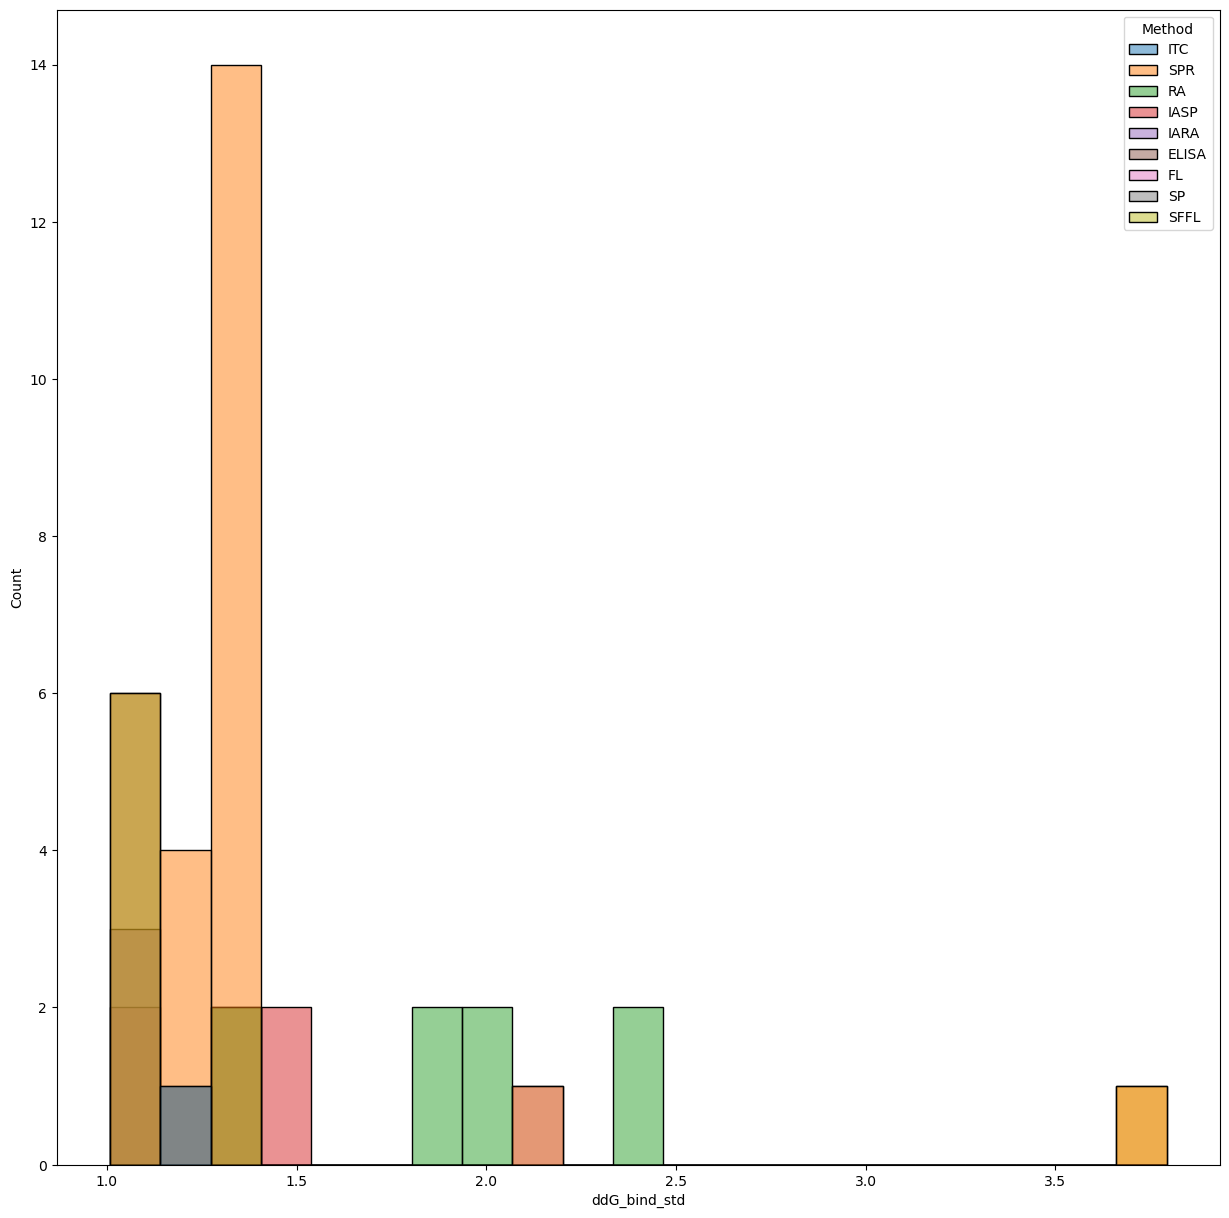

In [31]:
fig = plt.figure(figsize=(15, 15))
#sns.histplot(data=S4169_merged, x="ddG_bind_rev", hue="Method")
sns.histplot(x=skempi2_mm.loc[skempi2_mm['ddG_bind_std']>1]["ddG_bind_std"],
             hue=skempi2_mm.loc[skempi2_mm['ddG_bind_std']>1]["Method"])

<Axes: xlabel='Method', ylabel='count'>

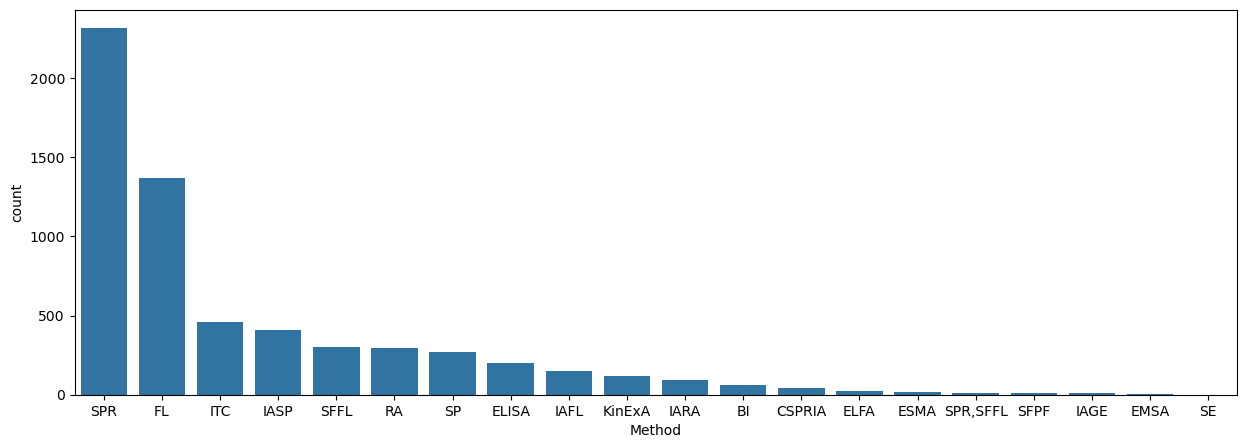

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=skempi2_avg, x='Method', order=skempi2_avg['Method'].value_counts().index, ax=ax)

<Axes: xlabel='Method', ylabel='count'>

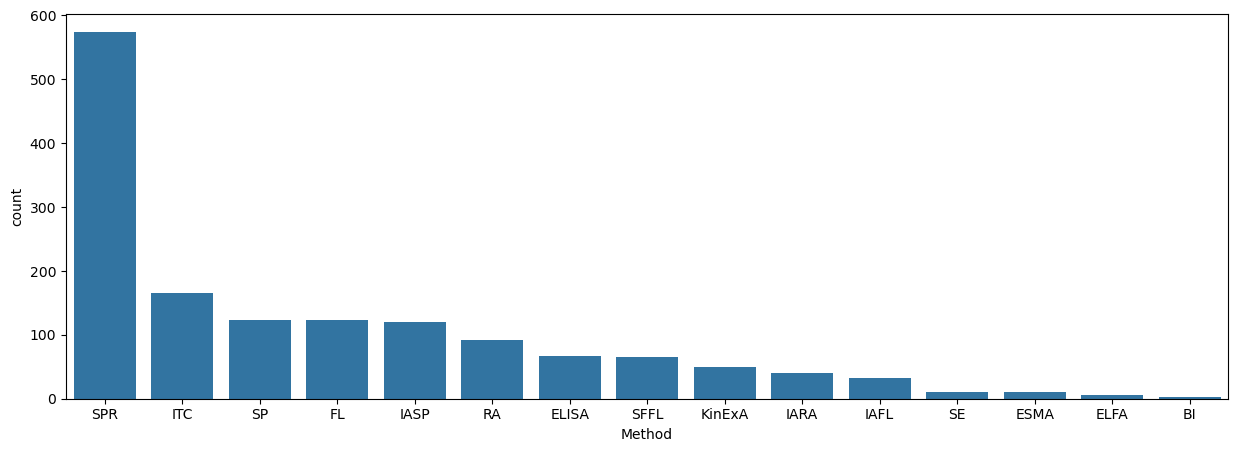

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=skempi2_mm, x='Method', order=skempi2_mm['Method'].value_counts().index, ax=ax)

<Axes: xlabel='Method', ylabel='ddG_bind_std'>

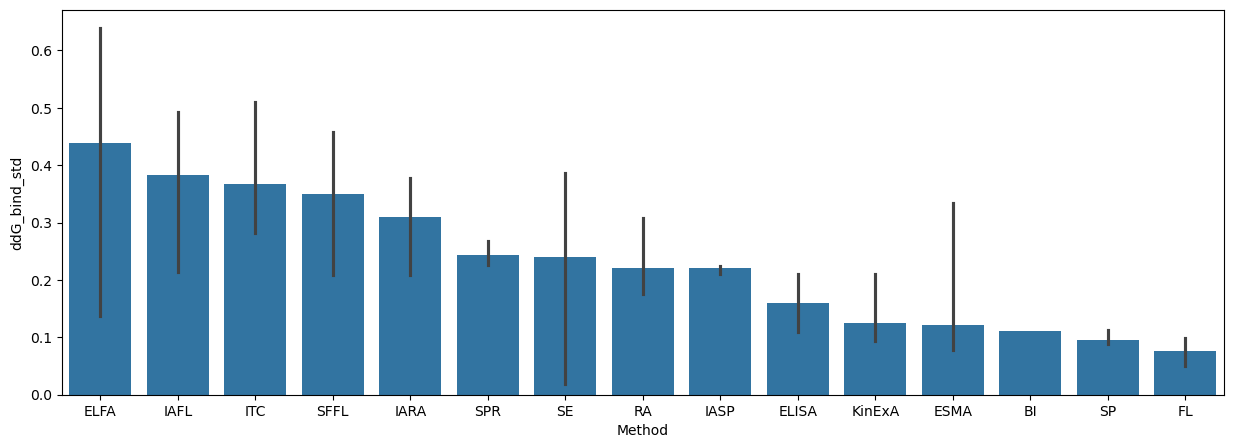

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=skempi2_mm, x='Method', y='ddG_bind_std',
            order=skempi2_mm[['Method', 'ddG_bind_std']].groupby(['Method']).median().sort_values(by=['ddG_bind_std'], ascending=False).index,
            ax=ax,
            estimator='median')

<Axes: xlabel='ddG_bind', ylabel='Count'>

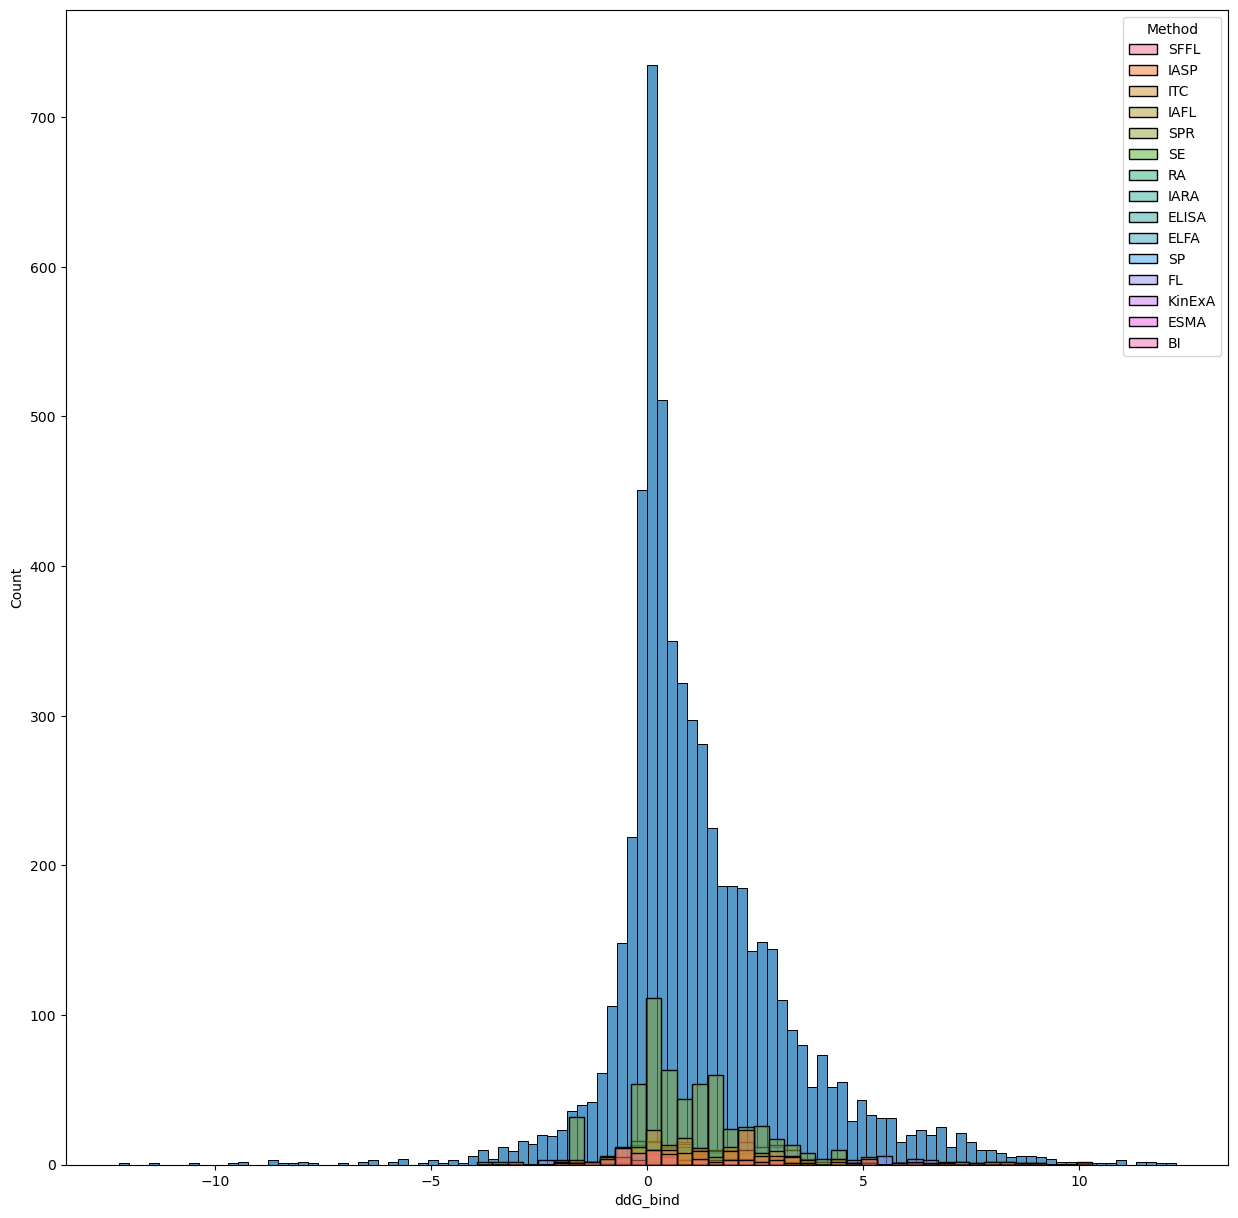

In [35]:
fig = plt.figure(figsize=(15, 15))
#sns.histplot(data=S4169_merged, x="ddG_bind_rev", hue="Method")
sns.histplot(x=skempi2_avg["ddG_bind"])
sns.histplot(x=skempi2_mm["ddG_bind_mean"],
             hue=skempi2_mm["Method"])

In [17]:
dif_chains = skempi2_avg[['PDB_ID', 'Chains']].groupby(['PDB_ID', 'Chains']).size().reset_index()
s = dif_chains.groupby(['PDB_ID']).size().reset_index()
s.loc[s[0]>1]
dif_chains.loc[dif_chains['PDB_ID'].isin(['2C5D', '3SE3', '3SE4'])]

PDB_ID Chains   0
145   2C5D   ABCD  19
146   2C5D     AC  16
262   3SE3     BA  47
263   3SE3     BC   2
264   3SE4     BA  18
265   3SE4     BC  17

In [18]:
# skempi2 = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi_v2.csv', sep=';')
# skempi2['PDB_ID'] = skempi2['#Pdb'].str.split('_').str[0]
# skempi2['index'] = skempi2.index.tolist()
# skempi2['case_ID'] = skempi2['index'].astype('str') + '_' + skempi2['PDB_ID']
#skempi2.to_csv('/groups/sbinlab/panf/SKEMPIv2/skempi2_mesure_mean.csv', index=False)

In [19]:
nick_pdbs = ['1JTG', '5E9D', '3SZK', '3BN9', '2J0T', '1KTZ', '3SGB', '3MZG', '1DAN', '1VFB', '1OGA']

In [20]:
skempi2.loc[(skempi2['#Pdb'].str.split("_").str[0].isin(nick_pdbs))&(skempi2['ddG_bind'].isna())]

index       #Pdb Mutation(s)_PDB Mutation(s)_cleaned  \
362     362  1VFB_AB_C          YB101A              YB101A   
631     631   2J0T_A_D       TD2R,VD4I           TD2R,VD4I   
2129   2129  1VFB_AB_C          YB101A              YB101A   

     iMutation_Location(s) Hold_out_type Hold_out_proteins Affinity_mut (M)  \
362                    COR         AB/AG             AB/AG              n.b   
631                COR,RIM           NaN          2J0T_A_D              n.b   
2129                   COR         AB/AG             AB/AG              n.b   

      Affinity_mut_parsed Affinity_wt (M)  ...  dS_mut (cal mol^(-1) K^(-1))  \
362                   NaN           2E-08  ...                           NaN   
631                   NaN           4E-10  ...                           NaN   
2129                  NaN        1.25E-08  ...                           NaN   

     dS_wt (cal mol^(-1) K^(-1)) Notes Method SKEMPI version  PDB_ID  \
362                          NaN   NaN    SPR              2    1VFB   
631                          NaN   NaN   IAFL              2    2J0T   
2129                         NaN   NaN    SPR              2    1VFB   

      no_proper_value  dG_bind_WT  dG_bind_MUT ddG_bind  
362              True  -10.498011          NaN      NaN  
631              True  -12.814660          NaN      NaN  
2129             True  -10.776341          NaN      NaN  

[3 rows x 35 columns]

In [24]:
nick_pdbs_df = skempi2_avg.loc[skempi2_avg['PDB_ID'].isin(nick_pdbs)]

In [30]:
nick_pdbs_df['#Pdb'].unique()

array(['1VFB_AB_C', '2J0T_A_D', '1KTZ_A_B', '1JTG_A_B', '3BN9_B_CD',
       '3MZG_A_B', '1DAN_HL_UT', '3SGB_E_I', '1OGA_ABC_DE', '5E9D_AB_CDE',
       '3SZK_AB_C'], dtype=object)

In [21]:
# FOR FUTUTRE ANALYSIS: No binding detected, I would guess predictions should be >15 kcal/mol
# skempi2_filt.loc[skempi2_filt['Affinity_mut (M)']=='n.b']
# skempi2.loc[skempi2['Affinity_mut (M)'] == 'n.b', 'dG_bind_MUT'] = 100

In [ ]:
with open("file.txt", "w") as output:
    output.write(str(values))